In [1]:
import datetime
import torch
import torch.nn as nn
import os
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import skimage.measure
from torch.utils.data import DataLoader

In [2]:
path = (r'C:\Users\mylar\OneDrive\Área de Trabalho\PredRNN-Radar')

data loaded


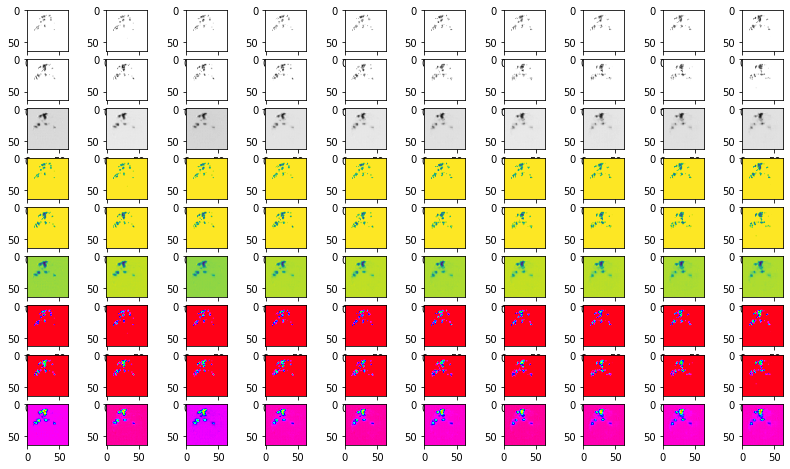

In [4]:
class SpatioTemporalLSTMCell(nn.Module):
    def __init__(self, in_channel, num_hidden, width, filter_size, stride, layer_norm):
        super(SpatioTemporalLSTMCell, self).__init__()

        self.num_hidden = num_hidden
        self.padding = filter_size // 2
        self._forget_bias = 1.0
        if layer_norm:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 7, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
                nn.LayerNorm([num_hidden * 7, width, width])
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
                nn.LayerNorm([num_hidden * 4, width, width])
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 3, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
                nn.LayerNorm([num_hidden * 3, width, width])
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
                nn.LayerNorm([num_hidden, width, width])
            )
        else:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 7, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 3, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=filter_size, stride=stride, padding=self.padding,
                          bias=False),
            )
        self.conv_last = nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x_t, h_t, c_t, m_t):
        x_concat = self.conv_x(x_t)
        h_concat = self.conv_h(h_t)
        m_concat = self.conv_m(m_t)
        i_x, f_x, g_x, i_x_prime, f_x_prime, g_x_prime, o_x = torch.split(x_concat, self.num_hidden, dim=1)
        i_h, f_h, g_h, o_h = torch.split(h_concat, self.num_hidden, dim=1)
        i_m, f_m, g_m = torch.split(m_concat, self.num_hidden, dim=1)

        i_t = torch.sigmoid(i_x + i_h)
        f_t = torch.sigmoid(f_x + f_h + self._forget_bias)
        g_t = torch.tanh(g_x + g_h)

        delta_c = i_t * g_t
        c_new = f_t * c_t + delta_c

        i_t_prime = torch.sigmoid(i_x_prime + i_m)
        f_t_prime = torch.sigmoid(f_x_prime + f_m + self._forget_bias)
        g_t_prime = torch.tanh(g_x_prime + g_m)

        delta_m = i_t_prime * g_t_prime
        m_new = f_t_prime * m_t + delta_m

        mem = torch.cat((c_new, m_new), 1)
        o_t = torch.sigmoid(o_x + o_h + self.conv_o(mem))
        h_new = o_t * torch.tanh(self.conv_last(mem))

        return h_new, c_new, m_new, delta_c, delta_m


class RNN(nn.Module):
    def __init__(self, num_layers, num_hidden, configs):
        super(RNN, self).__init__()

        self.configs = configs
        
        patch_size = 4
        img_channel = 1
        img_width = 100
        filter_size = 5
        stride = 1
        layer_norm = 0
        self.frame_channel = patch_size * patch_size * img_channel
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.input_length = 10
        self.total_length = 20
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.reverse_scheduled_sampling = 1
        self.decouple_beta = 0.1
        cell_list = []

        width = img_width // patch_size
        self.MSE_criterion = nn.MSELoss()

        for i in range(num_layers):
            in_channel = self.frame_channel if i == 0 else num_hidden[i - 1]
            cell_list.append(
                SpatioTemporalLSTMCell(in_channel, num_hidden[i], width, filter_size,
                                       stride, layer_norm)
            )
        self.cell_list = nn.ModuleList(cell_list)
        self.conv_last = nn.Conv2d(num_hidden[num_layers - 1], self.frame_channel, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        
        adapter_num_hidden = num_hidden[0]
        self.adapter = nn.Conv2d(adapter_num_hidden, adapter_num_hidden, 1, stride=1, padding=0, bias=False)

    def forward(self, frames_tensor, mask_true):
        
        frames = frames_tensor.permute(0, 1, 4, 2, 3).contiguous()
        mask_true = mask_true.permute(0, 1, 4, 2, 3).contiguous()
        batch = frames.shape[0]
        height = frames.shape[3]
        width = frames.shape[4]

        next_frames = []
        h_t = []
        c_t = []
        delta_c_list = []
        delta_m_list = []

        decouple_loss = []

        for i in range(self.num_layers):
            zeros = torch.zeros([batch, self.num_hidden[i], height, width]).to(self.device)
            h_t.append(zeros)
            c_t.append(zeros)
            delta_c_list.append(zeros)
            delta_m_list.append(zeros)

        memory = torch.zeros([batch, self.num_hidden[0], height, width]).to(self.device)

        for t in range(self.total_length - 1):
            
            if t == 0:
                net = frames[:, t]
            else:
                net = mask_true[:, t - 1] * frames[:, t] + (1 - mask_true[:, t - 1]) * x_gen

            h_t[0], c_t[0], memory, delta_c, delta_m = self.cell_list[0](net, h_t[0], c_t[0], memory)
            delta_c_list[0] = F.normalize(self.adapter(delta_c).view(delta_c.shape[0], delta_c.shape[1], -1), dim=2)
            delta_m_list[0] = F.normalize(self.adapter(delta_m).view(delta_m.shape[0], delta_m.shape[1], -1), dim=2)

            for i in range(1, self.num_layers):
                h_t[i], c_t[i], memory, delta_c, delta_m = self.cell_list[i](h_t[i - 1], h_t[i], c_t[i], memory)
                delta_c_list[i] = F.normalize(self.adapter(delta_c).view(delta_c.shape[0], delta_c.shape[1], -1), dim=2)
                delta_m_list[i] = F.normalize(self.adapter(delta_m).view(delta_m.shape[0], delta_m.shape[1], -1), dim=2)

            x_gen = self.conv_last(h_t[self.num_layers - 1])
            next_frames.append(x_gen)
            
            for i in range(0, self.num_layers):
                decouple_loss.append(
                    torch.mean(torch.abs(torch.cosine_similarity(delta_c_list[i], delta_m_list[i], dim=2))))

        decouple_loss = torch.mean(torch.stack(decouple_loss, dim=0))
        
        next_frames = torch.stack(next_frames, dim=0).permute(1, 0, 3, 4, 2).contiguous()
        loss = self.MSE_criterion(next_frames, frames_tensor[:, 1:]) + self.decouple_beta * decouple_loss
        return next_frames, loss


def train_model(start_epoch=0):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    
    error = nn.MSELoss()
    count = 0

    for epoch in range(start_epoch, num_epochs):
        loss_list = []
        loss_test_list = []
        model.train()
        for i, (x, y) in enumerate(train_loader):
            inputs = reshape_tensor(x, y) 
            optimizer.zero_grad()
            outputs, loss = model(inputs, mask_true)
            loss.backward()
            optimizer.step()
            count += 1
            loss_list.append(loss.item())
            if count % 10 == 0:
                
                print('Epoch:%d  Iteration: %d  Loss: %f' % (epoch, count, loss.item()))
        
        model.eval()
        with torch.no_grad():
            for j, (x_test, y_test) in enumerate(test_loader):
                inputs_test = reshape_tensor(x_test, y_test)
                outputs_test, loss_test = model(inputs_test, mask_true)
                loss_test_list.append(loss_test.item())
        np.save('PredRNN/loss/loss_train_%d.npy'%(epoch), np.array(loss_list))
        np.save('PredRNN/loss/loss_test_%d.npy'%(epoch), np.array(loss_test_list))
        torch.save(model.state_dict(), 'PredRNN/PredRNN_%d.pt' % (epoch))


def reshape_back(patch_tensor):
    patch_tensor = patch_tensor.detach().cpu().numpy()
    patch_size = 4
    assert 5 == patch_tensor.ndim
    batch_size = np.shape(patch_tensor)[0]
    seq_length = np.shape(patch_tensor)[1]
    patch_height = np.shape(patch_tensor)[2]
    patch_width = np.shape(patch_tensor)[3]
    channels = np.shape(patch_tensor)[4]
    img_channels = channels // (patch_size * patch_size)
    a = np.reshape(patch_tensor, [batch_size, seq_length,
                                  patch_height, patch_width,
                                  patch_size, patch_size,
                                  img_channels])
    b = np.transpose(a, [0, 1, 2, 4, 3, 5, 6])
    img_tensor = np.reshape(b, [batch_size, seq_length,
                                patch_height * patch_size,
                                patch_width * patch_size,
                                img_channels])
    return img_tensor

def reshape_tensor(x, y):
    
    patch_size = 4
    
    input_tensor = torch.cat([x, y], dim=1)
    
    batch_size, seq_length, num_channels, img_height, img_width = input_tensor.unsqueeze(2).shape  # B, T, C, H, W
    
    a = torch.reshape(input_tensor, [batch_size, seq_length,
                                    img_height // patch_size, patch_size,
                                    img_width // patch_size, patch_size,
                                    num_channels])
    b = torch.transpose(a, 3, 4)
    patch_tensor = torch.reshape(b, [batch_size, seq_length,
                                     img_height // patch_size,
                                     img_width // patch_size,
                                     patch_size * patch_size * num_channels])
    input_tensor = patch_tensor.to(device)
    return input_tensor

def draw_prediction():
    x, y = next(iter(train_loader))
    inputs = reshape_tensor(x, torch.zeros_like(x))
    outputs, loss = model(inputs, mask_true)
    y_pred = reshape_back(outputs)
    
    np.save(os.path.join(path,'target'),np.array(y.detach().cpu()))
   
    np.save(os.path.join(path,'prediction'),np.array(y_pred))
    
    
    fig, axes = plt.subplots(nrows=9, ncols=10, figsize=(14, 8))
    for i in range(10):
        axes[0][i].imshow(x[0, i, :, :],cmap="gray")
        axes[1][i].imshow(y[0, i, :, :],cmap="gray")
        axes[2][i].imshow(y_pred[0, i+9, :, :, 0],cmap="gray")
        
        axes[3][i].imshow(x[0, i, :, :])
        axes[4][i].imshow(y[0, i, :, :])
        axes[5][i].imshow(y_pred[0, i+9, :, :, 0])
        
        axes[6][i].imshow(x[0, i, :, :],cmap="hsv") 
        axes[7][i].imshow(y[0, i, :, :],cmap="hsv")
        axes[8][i].imshow(y_pred[0, i+9, :, :, 0],cmap="hsv")
        
        
    plt.show()


if __name__ == '__main__':
    if not os.path.exists('PredRNN/loss'):
        os.makedirs('PredRNN/loss')
    data = np.load(r'C:\Users\mylar\OneDrive\Área de Trabalho\PredRNN-Radar\data\dataset-original.npy')

    data = data / 255
    

    train_len = 800
    X_train, X_test = data[:10, :8, :, :], data[:10, 8:, :, :]
    Y_train, Y_test = data[10:, :8, :, :], data[10:, 8:, :, :]
    X_train = torch.FloatTensor(X_train).permute(1, 0, 2, 3)
    Y_train = torch.FloatTensor(Y_train).permute(1, 0, 2, 3)
    X_test = torch.FloatTensor(X_test).permute(1, 0, 2, 3)
    Y_test = torch.FloatTensor(Y_test).permute(1, 0, 2, 3)

    batch_size = 8
    n_iters = 1000
    # num_epochs = n_iters / (len(X_train) / batch_size)
    num_epochs = 1000

    train = torch.utils.data.TensorDataset(X_train, Y_train)
    test = torch.utils.data.TensorDataset(X_test, Y_test)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
    print('data loaded')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = RNN(num_layers=2, num_hidden=[64, 64], configs=None)
    if device == 'cuda:0':
        model.cuda()

    device = torch.device('cuda')
    model.to(device)
    
    lag = 10
    pred_step = 10
    train_len = 800
    
    mask_true = torch.zeros([8, 18, 16, 16, 16])
    mask_true[:, :9, :, :, :] = 1
    mask_true = mask_true.to(device)
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('PredRNN/PredRNN-Radar.pt'))
    else:
        state_dict = torch.load('PredRNN/PredRNN-Radar.pt',
                                map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        
    draw_prediction()

NameError: name 'inputs' is not defined